In [1]:
!pip install -q mlflow==2.5.0 pytorch-lightning protobuf==3.20.1 lightning==2.1.2

In [5]:
import mlflow
mlflow.set_tracking_uri("http://app-mlflow-2-bvdjz:5000")
mlflow.set_experiment("pytorch-mnist")

<Experiment: artifact_location='/project/end-to-end-tutorial/phapplications/mlflow-2-bvdjz/mlruns/1', creation_time=1701679700375, experiment_id='1', last_update_time=1701679700375, lifecycle_stage='active', name='pytorch-mnist', tags={}>

In [6]:
import os

import lightning as L
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

import mlflow.pytorch
from mlflow import MlflowClient


class MNISTModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(28 * 28, 10)
        self.accuracy = Accuracy("multiclass", num_classes=10)

    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        pred = logits.argmax(dim=1)
        acc = self.accuracy(pred, y)

        # PyTorch `self.log` will be automatically captured by MLflow.
        self.log("train_loss", loss, on_epoch=True)
        self.log("acc", acc, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)


def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print(f"run_id: {r.info.run_id}")
    print(f"artifacts: {artifacts}")
    print(f"params: {r.data.params}")
    print(f"metrics: {r.data.metrics}")
    print(f"tags: {tags}")


# Initialize our model.
mnist_model = MNISTModel()

# Load MNIST dataset.
train_ds = MNIST(
    os.getcwd(), train=True, download=True, transform=transforms.ToTensor()
)
# Only take a subset of the data for faster training.
indices = torch.arange(32)
train_ds = Subset(train_ds, indices)
train_loader = DataLoader(train_ds, batch_size=8)

# Initialize a trainer.
trainer = L.Trainer(max_epochs=30)

# Auto log all MLflow entities
mlflow.pytorch.autolog()

# Train the model.
with mlflow.start_run() as run:
    trainer.fit(mnist_model, train_loader)

# Fetch the auto logged parameters and metrics.
print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
2023/12/11 15:46:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.8/site-packages/mlflow/pytorch/_lightning_autolog.py:351: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.5 and may not succeed with packages outsi

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
2023/12/11 15:46:40 WARNING mlflow.utils.requirements_utils: Found torch version (1.13.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==1.13.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/12/11 15:46:45 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.14.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torchvision==0.14.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2023/12/11 15:46:45 WARNING mlflow.utils.requirements_utils: Found torchaudio version (0.13.1+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 't

run_id: c10cabc029524233971057b71080ccc7
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {'epochs': '30', 'optimizer_name': 'Adam', 'lr': '0.02', 'betas': '(0.9, 0.999)', 'eps': '1e-08', 'weight_decay': '0', 'amsgrad': 'False', 'maximize': 'False', 'foreach': 'None', 'capturable': 'False', 'differentiable': 'False', 'fused': 'False'}
metrics: {'train_loss': 1.871020793914795, 'train_loss_step': 2.3025853633880615, 'acc': 0.25, 'acc_step': 0.0, 'train_loss_epoch': 1.871020793914795, 'acc_epoch': 0.25}
tags: {'Mode': 'training'}


In [ ]:
# ===== Prediction =====

In [7]:
from torchvision import transforms
from torchvision.datasets import MNIST

# 加載MNIST數據集
mnist = MNIST(root='.', train=True, download=True, transform=transforms.ToTensor())

In [8]:
import torch

# 取前5個樣本
subset_indices = torch.arange(5)
mnist_subset = torch.utils.data.Subset(mnist, subset_indices)

# 提取圖像和標籤
images, labels = zip(*[mnist_subset[i] for i in range(len(mnist_subset))])

In [9]:
images_np = [image.squeeze().numpy() for image in images]

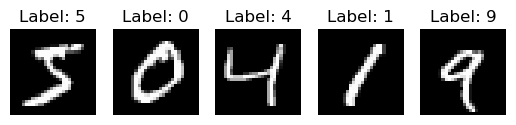

In [10]:
import matplotlib.pyplot as plt

for i, (img, label) in enumerate(zip(images_np, labels)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.show()

In [11]:
mnist_example = torch.tensor(img)
mnist_example_flat = mnist_example.view(-1, 28*28)

In [12]:
with torch.no_grad():
    logits = mnist_model(mnist_example_flat)
    predicted_class = logits.argmax(dim=1)

print(f"Predicted Class: {predicted_class.item()}")

Predicted Class: 0
